CSP Solution (Coordinates): [(1, 13), (1, 17), (2, 2), (2, 9), (5, 5), (5, 12), (5, 16), (6, 1)]


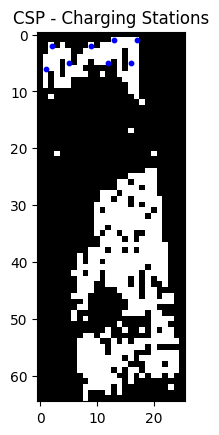

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from simpleai.search import CspProblem, backtrack

# Load tile map (1 = valid, 0 = invalid)
tiles = np.load("tiles.npy")
rows, cols = tiles.shape

TILE_SIZE = 252  # meters per tile
MIN_DIST_METERS = 1000
MAX_DIST_METERS = 3000

MIN_DIST_TILES = MIN_DIST_METERS / TILE_SIZE
MAX_DIST_TILES = MAX_DIST_METERS / TILE_SIZE

# Valid coordinates (white pixels == 1)
valid_coords = [(r, c) for r in range(rows) for c in range(cols) if tiles[r, c] == 1]

# Constraints
def min_distance_constraint(variables, values):
    distance = math.sqrt((values[0][0] - values[1][0]) ** 2 + (values[0][1] - values[1][1]) ** 2)
    return distance >= MIN_DIST_TILES

def max_distance_constraint(variables, values):
    n = len(values)
    distances = []
    for i in range(n):
        min_dist = np.inf
        for j in range(n):
            if i != j:
                dist = math.sqrt((values[i][0] - values[j][0]) ** 2 + (values[i][1] - values[j][1]) ** 2)
                min_dist = min(min_dist, dist)
        distances.append(min_dist)
    
    return all(d <= MAX_DIST_TILES for d in distances)

# CSP problem definition
variables = [f"S{i}" for i in range(8)]
domains = {var: valid_coords for var in variables}
constraints = [(variables, max_distance_constraint)]

for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        constraints.append(((variables[i], variables[j]), min_distance_constraint))

csp_problem = CspProblem(variables, domains, constraints)
solution_csp = backtrack(csp_problem)
solution_csp = list(solution_csp.values())

print("CSP Solution (Coordinates):", solution_csp)

# Plot CSP solution
fig, ax = plt.subplots()
ax.imshow(tiles, cmap='gray')
for station in solution_csp:
    ax.scatter(station[1], station[0], c='blue', s=10)
plt.title("CSP - Charging Stations")
plt.show()



Greedy Stations: [(37, 15), (54, 15), (5, 10), (25, 16), (44, 13), (57, 9), (53, 20), (3, 2)]
Total Visible Area (Tiles): 474


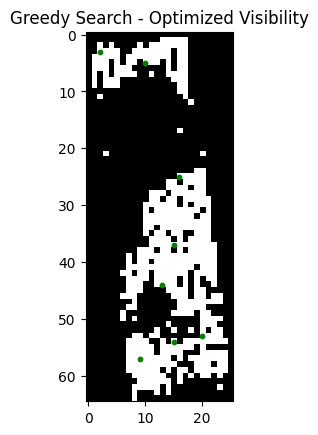

In [5]:
def greedy_visibility_selection(valid_coords, n_stations, radius_tiles=8):
    selected_stations = []
    covered_tiles = set()
    
    for _ in range(n_stations):
        best_candidate = None
        best_additional_coverage = -1
        
        for candidate in valid_coords:
            if candidate in selected_stations:
                continue
            
            # Calculate additional coverage if we add this candidate
            temp_coverage = set(covered_tiles)
            r0, c0 = candidate
            for dr in range(-radius_tiles, radius_tiles + 1):
                for dc in range(-radius_tiles, radius_tiles + 1):
                    rr, cc = r0 + dr, c0 + dc
                    if 0 <= rr < rows and 0 <= cc < cols:
                        dist = math.sqrt(dr**2 + dc**2)
                        if dist <= radius_tiles and tiles[rr, cc] == 1:
                            temp_coverage.add((rr, cc))
            
            additional_coverage = len(temp_coverage) - len(covered_tiles)
            
            if additional_coverage > best_additional_coverage:
                best_additional_coverage = additional_coverage
                best_candidate = candidate
        
        if best_candidate:
            selected_stations.append(best_candidate)
            # Update covered_tiles
            r0, c0 = best_candidate
            for dr in range(-radius_tiles, radius_tiles + 1):
                for dc in range(-radius_tiles, radius_tiles + 1):
                    rr, cc = r0 + dr, c0 + dc
                    if 0 <= rr < rows and 0 <= cc < cols:
                        dist = math.sqrt(dr**2 + dc**2)
                        if dist <= radius_tiles and tiles[rr, cc] == 1:
                            covered_tiles.add((rr, cc))
        else:
            print("No more candidates found!")
            break
    
    return selected_stations, len(covered_tiles)

# Greedy Execution
greedy_stations, greedy_coverage = greedy_visibility_selection(valid_coords, 8)

print("Greedy Stations:", greedy_stations)
print("Total Visible Area (Tiles):", greedy_coverage)

# Plot Greedy result
fig, ax = plt.subplots()
ax.imshow(tiles, cmap='gray')
for station in greedy_stations:
    ax.scatter(station[1], station[0], c='green', s=10)
plt.title("Greedy Search - Optimized Visibility")
plt.show()


Initial visibility: 4.061552812808831
Initial state: [(1, 13), (1, 17), (2, 2), (2, 9), (5, 5), (5, 12), (5, 16), (6, 1)]
Iteration: 2 Visibility: 7.959078051750565 Temperature: 95.0
Iteration: 3 Visibility: 5.061552812808831 Temperature: 90.25
Iteration: 4 Visibility: 4.046164609606623 Temperature: 85.73749999999998
Iteration: 5 Visibility: 6.021058330350615 Temperature: 81.45062499999999
Iteration: 6 Visibility: 6.275220377647229 Temperature: 77.37809374999998
Iteration: 7 Visibility: 7.295911010221784 Temperature: 73.50918906249998
Iteration: 8 Visibility: 5.547067468384698 Temperature: 69.83372960937497
Iteration: 9 Visibility: 4.865526920268848 Temperature: 66.34204312890623
Iteration: 10 Visibility: 5.764247899605225 Temperature: 63.02494097246091
Iteration: 11 Visibility: 5.4038641873226085 Temperature: 59.87369392383787
Iteration: 12 Visibility: 6.206803423043277 Temperature: 56.880009227645964
Iteration: 13 Visibility: 6.943387814610024 Temperature: 54.03600876626366
Iteration

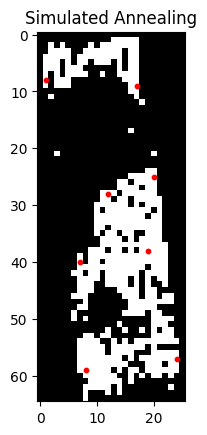

In [ ]:
import random
import math

initial_state = solution_csp

class Stations(object): 
    def __init__(self, initial_state): 
        self.stations = initial_state.copy()
        self.n_stations = len(self.stations)
        
    def visibility(self): 
        n_stations = self.n_stations
        distances = np.zeros((n_stations, n_stations))
        
        for i in range(n_stations):
            for j in range(i+1, n_stations):
                distances[i, j] = math.sqrt(
                    (self.stations[i][0] - self.stations[j][0]) ** 2 +
                    (self.stations[i][1] - self.stations[j][1]) ** 2
                )
                distances[j, i] = distances[i, j]

        # Avoid diagonals
        np.fill_diagonal(distances, np.inf)

        # Minimum distance from each station to its nearest neighbor
        min_distances = np.min(distances, axis=1)

        # The objective will be to maximize the average of these minimum distances
        return np.mean(min_distances)
        
    def neighbor(self): 
        '''
        Changes one station for another random valid one.
        '''
        new_state = self.stations.copy()

        # Choose a random station to move
        idx = random.randint(0, self.n_stations - 1)

        # Select a new position from the valid coordinates
        new_coord = random.choice(valid_coords)
        
        new_state[idx] = new_coord

        return Stations(new_state)

# Initial parameters for simulated annealing
t0 = 100.0      # Initial temperature
alpha = 0.95    # Cooling factor
t = t0
step = 1

# Initial instance
st = Stations(initial_state)
visibility = st.visibility()

print("Initial visibility:", visibility)
print("Initial state:", st.stations)

# Main simulated annealing loop
while t > 0.05: 
    # Calculate temperature
    t = t0 * math.pow(alpha, step)
    step += 1
    
    # Get a random neighbor
    neighbor = st.neighbor()
    new_visibility = neighbor.visibility()
    
    # Evaluate the neighbor
    if new_visibility > visibility: 
        st = neighbor
        visibility = new_visibility
    else: 
        # Probability of accepting a worse neighbor
        p = math.exp(-(visibility - new_visibility) / t)
        if p >= random.random():
            st = neighbor
            visibility = new_visibility
    
    print("Iteration:", step, "Visibility:", visibility, "Temperature:", t)

print("\nFinal state:", st.stations)
print("Final visibility:", visibility)

# Plot the stations
rows, cols = tiles.shape

fig, ax = plt.subplots()
ax.imshow(tiles, cmap='gray')

# Plot the final stations
for station in st.stations:
    ax.scatter(station[1], station[0], c='red', s=10)

plt.title('Simulated Annealing')
plt.show()
